<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/RAPID/notebooks/RAPID_calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting UniProt proteomes for Tempura species

## Setup

In [1]:
!pip install BIO
!sudo apt install clustalw
# !pip install toytree toyplot
!git clone -b RAPID https://github.com/alibekk93/IDP_analysis
!cd /content/IDP_analysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.4/279.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  clustalx seaview
The following NEW packages will be installed:
  clustalw
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 275 kB of archives.
After this operation, 818 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 clustalw amd64 2.1+lgpl-7 [275 kB]
Fetched 275 kB in 0s (1,163 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling

In [2]:
from IDP_analysis.packages_import import *
from IDP_analysis.idp_in_bacteria_functions import *

/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [26]:
sns.set_theme(context='paper', style='white',  palette='colorblind')

Loading Tempura dataset

In [4]:
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/200617_TEMPURA.csv', index_col=0)
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_bacteria_uniprot.csv', index_col=0)
tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_filtered.csv', index_col=0)

Only keeping bacteria with available assembly or accession numbers

In [5]:
# tempura = tempura[tempura['superkingdom']=='Bacteria']
# tempura.dropna(subset='assembly_or_accession', inplace=True)
# tempura.reset_index(drop=True, inplace=True)

Classifying bacteria into groups:
1. Psychrophile: OGT <= 20
2. Mesophile: 20 < OGT <= 40
2. Thermophile: 40 < OGT

While this may be quite liberal, some "psychrohiles" with OGT = 20 have *antarctica* in their species name, so it should be fair enough

In [6]:
tempura['group'] = pd.cut(tempura['Topt_ave'], bins=[-float('inf'), 20, 40, float('inf')],
                          labels=['psychrophilic', 'mesophilic', 'thermophilic'])

Loading all_proteins

In [7]:
# all_proteins = pd.read_csv('/content/all_proteins.csv', index_col=0)
# all_proteins_filtered = pd.read_csv('/content/all_proteins_filtered.csv', index_col=0)
all_proteins_rapid = pd.read_csv('/content/all_proteins_rapid.csv', index_col=0)
all_proteins_disordered = pd.read_csv('/content/all_proteins_disordered.csv', index_col=0)

Merging all_proteins with temura

In [8]:
all_protein_tempura = all_proteins_rapid.merge(tempura, left_on='Species', right_on='genus_and_species')
all_protein_tempura_idp = all_proteins_disordered.merge(tempura, left_on='Species', right_on='genus_and_species')

Loading cluster dataframes

In [9]:
interesting_clusters = pd.read_csv('/content/IDP_analysis/datafiles/clusters/interesting_clusters.csv', index_col=0)
disordered_clusters = pd.read_csv('/content/IDP_analysis/datafiles/clusters/disordered_clusters.csv', index_col=0)

Loading RAPID_disorder values

In [10]:
# rapid_disorder_values = pd.read_csv('/content/IDP_analysis/datafiles/RAPID/RAPID_disorder_values.csv', index_col=0)

## Combining partial RAPID results and loading into all_proteins

In [ ]:
rapid_disorder_values = pd.DataFrame(columns = ['Prot. ID', 'Disorder Content %'])

In [ ]:
# set number of csv files with partial RAPID calculation results
n = 17
# iterate through each file and concatenate to all_proteins_filtered
for i in tqdm(range(n)):
  # make filename with addition of '0' if 1-9
  if i+1 < 10:
    filename = f'0{i+1}.csv'
  else:
    filename = f'{i+1}.csv'
  # read csv with RAPID result
  rapid_result = pd.read_csv(filename)
  rapid_result = rapid_result[['Prot. ID', 'Disorder Content %']]
  # append RAPID disorder prediciton to overall dataframe
  rapid_disorder_values = pd.concat([rapid_disorder_values, rapid_result], axis=0)

In [ ]:
# rapid_disorder_values.to_csv('RAPID_disorder_values.csv')

Appending RAPID disorder values to all_proteins_filtered

In [ ]:
# all_proteins_rapid = all_proteins_filtered.join(rapid_disorder_values.set_index('Prot. ID'),
#                                                    on='ID', how='inner')

In [ ]:
all_proteins_rapid['RAPID_disorder'] = all_proteins_rapid['Disorder Content %'] / 100
all_proteins_rapid.drop('Disorder Content %', axis=1, inplace=True)

# all_proteins_rapid['RAPID_fully_disordered'] = all_proteins_rapid['RAPID_disorder'] >= 0.5
# all_proteins_rapid['RAPID_n_disordered_residues'] = all_proteins_rapid['RAPID_disorder'] * all_proteins_rapid['Length']

In [ ]:
# all_proteins_rapid.to_csv('all_proteins_rapid.csv')

## FCR / NCPR filtering

In [11]:
def compute_fcr(row):
    aa_seq = row['Sequence']
    n = len(aa_seq)
    f_plus = sum(aa_seq.count(char) for char in ['R', 'K', 'H']) / n # Histidine?
    f_minus = sum(aa_seq.count(char) for char in ['D', 'E']) / n
    ncpr = abs(f_plus - f_minus)
    fcr = (f_plus + f_minus)
    return pd.Series([f_plus, f_minus, ncpr, fcr])

In [12]:
all_proteins_rapid[['f_plus', 'f_minus', 'ncpr', 'fcr']] = all_proteins_rapid.apply(compute_fcr, axis=1)

In [13]:
all_proteins_rapid['idp_type'] = None

In [14]:
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] < 0.25) & (all_proteins_rapid['ncpr'] < 0.25), 'idp_type'] = 1
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] >= 0.25) & (all_proteins_rapid['fcr'] <= 0.35) &\
                      (all_proteins_rapid['ncpr'] <= 0.35), 'idp_type'] = 2
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] > 0.35) & (all_proteins_rapid['ncpr'] <= 0.35), 'idp_type'] = 3
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] > 0.35) & (all_proteins_rapid['ncpr'] > 0.35) &\
                      (all_proteins_rapid['f_minus'] > 0.35), 'idp_type'] = 4
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] > 0.35) & (all_proteins_rapid['ncpr'] > 0.35) &\
                      (all_proteins_rapid['f_plus'] > 0.35), 'idp_type'] = 5

Filter out "disordered" proteins - these are either:
1. IDP type 3, 4 or 5
2. RAPID_disorder >= 0.5
3. Have at least 100 disordered residues as predicted by RAPID

The last point is to include longer proteins that just have a section of IDR. RAPID does not provide disorder at residue level, so it's as good as we can get to having a filter for 30 consecutive disordered residues

In [15]:
disordered_filter = (all_proteins_rapid['idp_type'] > 2) | \
                    (all_proteins_rapid['RAPID_disorder'] >= 0.5) | \
                    (all_proteins_rapid['RAPID_disorder'] * all_proteins_rapid['Length'] >= 100)
all_proteins_rapid['disordered'] = disordered_filter
all_proteins_disordered = all_proteins_rapid[disordered_filter]

In [16]:
# all_proteins_disordered.to_csv('all_proteins_disordered.csv')

In [17]:
# fig, ax = plt.subplots(figsize=(8,8))

# sns.scatterplot(data=all_proteins_rapid, x='f_plus', y='f_minus',
#                 hue='idp_type')

# ax.set_xlim(0, 0.75)
# ax.set_ylim(0, 0.75)

# fig.show()

In [18]:
# fig.savefig('IDP_types.svg')

In [19]:
# all_proteins_disordered.groupby('idp_type').mean()

In [20]:
type_counts = all_protein_tempura_idp.groupby(['group', 'idp_type']).size()

In [21]:
type_fractions = type_counts / all_protein_tempura_idp.groupby(['group']).size()

In [22]:
type_fractions_df = pd.DataFrame(type_fractions).reset_index()

In [23]:
type_fractions_df['group_IDPtype'] = type_fractions_df['group'].astype('str') + ' / ' + type_fractions_df['idp_type'].astype('str')

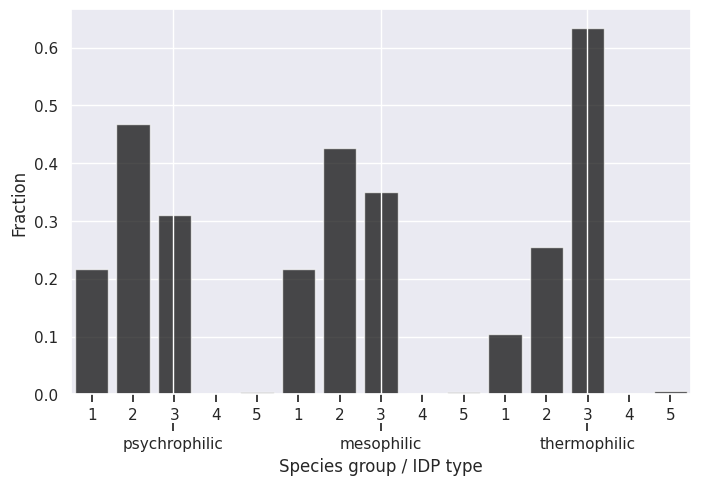

In [24]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=type_fractions_df, x='group_IDPtype', y=0, color='black', alpha=0.7)

ax.set_xticklabels(type_fractions_df['idp_type'])
ax.set_xlabel('')
ax.set_ylabel('Fraction')

ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('axes', -0.075))
ax2.set_frame_on(False)
ax2.patch.set_visible(False)
ax2.set_xticks([.165, .5, .833])
ax2.set_xticklabels(type_fractions_df['group'].unique())
ax2.set_xlabel('Species group / IDP type')

fig.show()

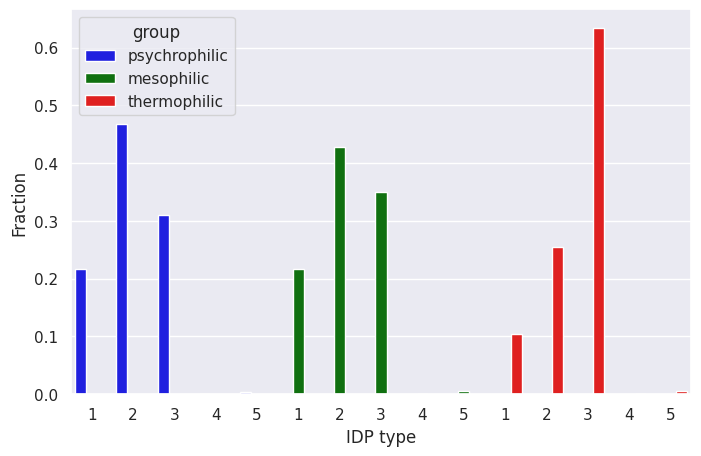

In [25]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=type_fractions_df, x='group_IDPtype', y=0, hue='group',
            palette=['blue', 'green', 'red'])

ax.set_xticklabels(type_fractions_df['idp_type'])
ax.set_xlabel('IDP type')
ax.set_ylabel('Fraction')

# plt.tight_layout()

fig.show()

## EDA for Overall IDP abundance ~ optimal temerature relationship

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 8))

# sns.kdeplot(data=all_proteins_rapid[all_proteins_rapid['RAPID_fully_disordered']],
#                 x='Length', y='RAPID_disorder', alpha=0.5, fill=True, ax=ax)
# ax.set_xlim(0, 500)
# fig.show()

In [68]:
species_rapid_disorder = all_proteins_rapid.groupby('Species').mean()[['RAPID_disorder']]
tempura = tempura.join(species_rapid_disorder, how='inner', on='genus_and_species')

species_rapid_idp_count = all_proteins_disordered.groupby('Species').count()[['RAPID_disorder']]
species_rapid_idp_count.columns = ['IDP_count']
tempura = tempura.join(species_rapid_idp_count, how='inner', on='genus_and_species')

species_rapid_protein_count = all_proteins_rapid.groupby('Species').count()[['RAPID_disorder']]
species_rapid_protein_count.columns = ['protein_count']
tempura = tempura.join(species_rapid_protein_count, how='inner', on='genus_and_species')
tempura['IDP_percentage'] = tempura['IDP_count'] / tempura['protein_count']

<ipython-input-68-1d0640aecf3f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  species_rapid_disorder = all_proteins_rapid.groupby('Species').mean()[['RAPID_disorder']]


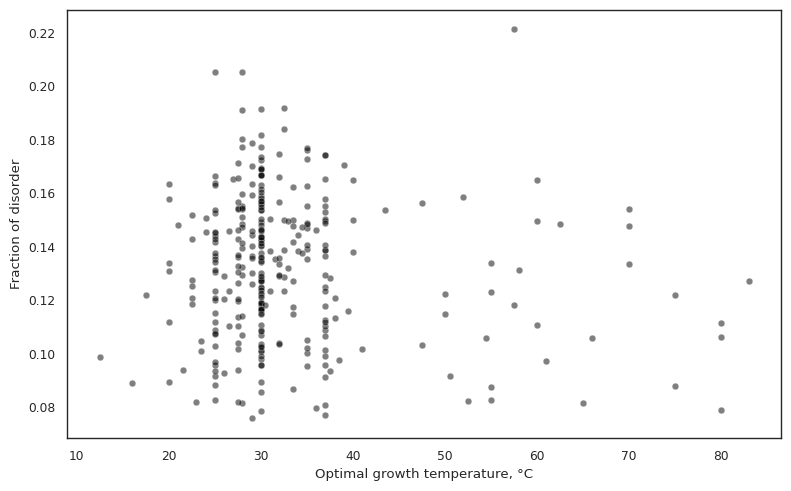

In [70]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=tempura, x='Topt_ave', y='RAPID_disorder', color='black', ax=ax, alpha=0.5)
plt.ylabel('Fraction of disorder')
plt.xlabel('Optimal growth temperature, °C')
plt.tight_layout()

fig.show()
# fig.savefig('FOD_OGT.svg')

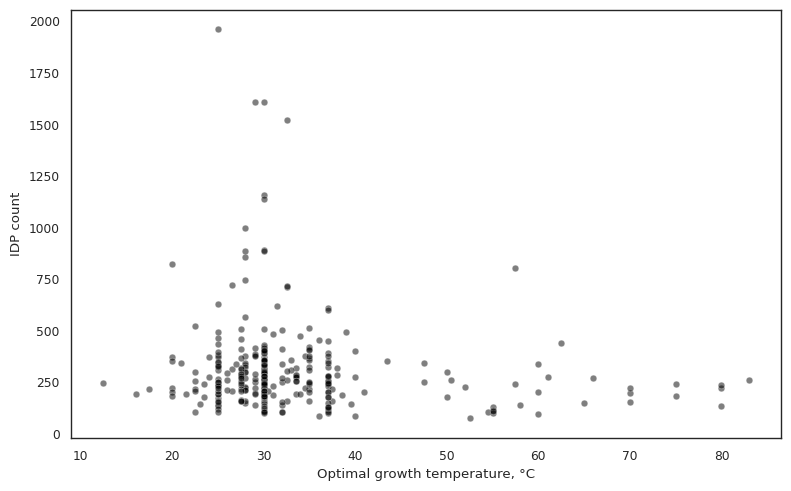

In [79]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=tempura, x='Topt_ave', y='IDP_count', color='black', ax=ax, alpha=0.5)
plt.ylabel('IDP count')
plt.xlabel('Optimal growth temperature, °C')
plt.tight_layout()

fig.show()
# fig.savefig('IDPcount_OGT.svg')

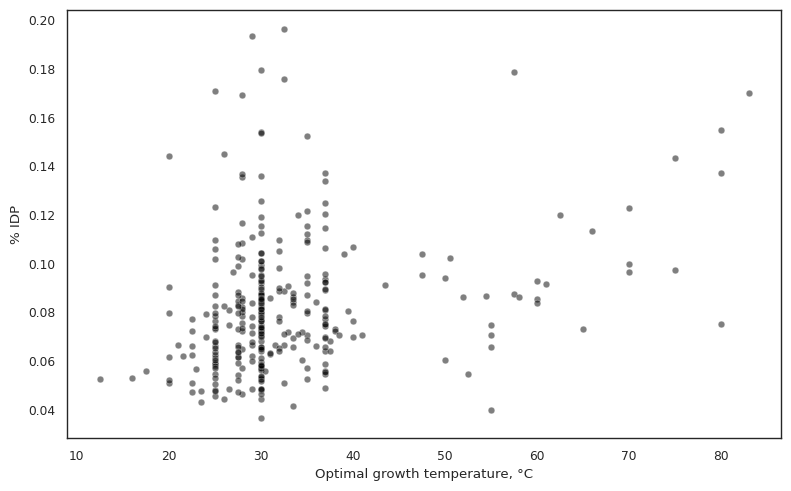

In [80]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=tempura, x='Topt_ave', y='IDP_percentage', color='black', ax=ax, alpha=0.5)
plt.ylabel('% IDP')
plt.xlabel('Optimal growth temperature, °C')
plt.tight_layout()

fig.show()
# fig.savefig('IDPpercentage_OGT.svg')

## Clustering all proteins using CD-HIT

In [ ]:
# # saving all proteins to a single fasta file
# with open('/content/all_proteins.fasta', 'w') as fasta_file:
#   for _, row in all_proteins_rapid.iterrows():
#     id = row['ID']
#     seq = row['Sequence']
#     fasta_file.write(f'>{id}\n{seq}\n')

CH-HIT ran on local system using command:
```
cd-hit -i all_proteins.fasta -o all_proteins_70 -c 0.7
```

Importing CD-HIT results

In [ ]:
clustered_proteins_file = '/content/IDP_analysis/datafiles/CD-HIT/all_proteins_70.clstr'

all_proteins_rapid['cluster'] = '0'
clusters = {}

# Read the clustered proteins file and store clusters
with open(clustered_proteins_file ,'r') as f:
  for line in f:
    if line.startswith('>Cluster'):
      cluster_id = int(line.strip().split()[1])
      clusters[cluster_id] = []
    else:
      protein_id = line.strip().split('>')[1].split('...')[0]
      clusters[cluster_id].append(protein_id)

In [ ]:
protein_cluster_mapping = {cid: proteins for cid, proteins in clusters.items()}
# Reverse cluster dictionary to have ID:cluster
protein_cluster_mapping = {protein_id: cluster for cluster, proteins in protein_cluster_mapping.items() for protein_id in proteins}
# Map clusters to df
all_proteins_rapid['cluster'] = all_proteins_rapid['ID'].map(protein_cluster_mapping)

We will filter to find clusters that:

1. Have at least 10 proteins
2. Have at least 1 disordered protein
2. Have at least 1 non-disordered protein

We will call these clusters `interesting_clusters` because they are, well, interesting

We will store clusters with only disordered proteins as `disordered_clusters`

In [ ]:
cluster_groups = all_proteins_rapid.groupby('cluster').agg({'disordered':['max', 'min'], 'ID':'count'})

In [ ]:
min_cluster_size = 10

only_disordered = cluster_groups[(cluster_groups['disordered']['min']) & (cluster_groups['ID']['count']>=min_cluster_size)].index
mixed_clusters = cluster_groups[(cluster_groups['disordered']['max']) & (~cluster_groups['disordered']['min']) & \
                                (cluster_groups['ID']['count']>=min_cluster_size)].index

In [ ]:
len(only_disordered)

95

In [ ]:
interesting_clusters = all_proteins_rapid[all_proteins_rapid['cluster'].isin(mixed_clusters)]
# interesting_clusters.to_csv('interesting_clusters.csv')

In [ ]:
disordered_clusters = all_proteins_rapid[all_proteins_rapid['cluster'].isin(only_disordered)]
# disordered_clusters.to_csv('disordered_clusters.csv')

Saving all proteins from `interesting_clusters` as `fasta` to predict their disorder using **fIDPnn**


In [ ]:
interesting_clusters = interesting_clusters[interesting_clusters['Length'] >= 20]

In [ ]:
!mkdir /content/IDP_analysis/clustered_fastas/

In [ ]:
# define the maximum sequences per file
max_sequences_per_file = 500

# split the DataFrame into chunks of max_sequences_per_file and save as FASTA files
for i, chunk in enumerate(range(0, len(interesting_clusters), max_sequences_per_file)):
  chunk_df = interesting_clusters.iloc[chunk:chunk + max_sequences_per_file]
  # create a FASTA file for the chunk
  fasta_file_path = f'/content/clustered_fastas/clustered_proteins_{i+1}.fasta'
  with open(fasta_file_path, 'w') as fasta_file:
    for _, row in chunk_df.iterrows():
      id = row['ID']
      seq = row['Sequence']
      fasta_file.write(f'>{id}\n{seq}\n')

In [ ]:
!zip -r /content/clustered_fastas.zip /content/IDP_analysis/clustered_fastas -i '*.fasta'
from google.colab import files
files.download('/content/clustered_fastas.zip')

  adding: content/clustered_fastas/clustered_proteins_11.fasta (deflated 46%)
  adding: content/clustered_fastas/clustered_proteins_3.fasta (deflated 47%)
  adding: content/clustered_fastas/clustered_proteins_12.fasta (deflated 46%)
  adding: content/clustered_fastas/clustered_proteins_18.fasta (deflated 48%)
  adding: content/clustered_fastas/clustered_proteins_23.fasta (deflated 52%)
  adding: content/clustered_fastas/clustered_proteins_4.fasta (deflated 49%)
  adding: content/clustered_fastas/clustered_proteins_6.fasta (deflated 45%)
  adding: content/clustered_fastas/clustered_proteins_1.fasta (deflated 59%)
  adding: content/clustered_fastas/clustered_proteins_19.fasta (deflated 46%)
  adding: content/clustered_fastas/clustered_proteins_2.fasta (deflated 44%)
  adding: content/clustered_fastas/clustered_proteins_9.fasta (deflated 47%)
  adding: content/clustered_fastas/clustered_proteins_7.fasta (deflated 48%)
  adding: content/clustered_fastas/clustered_proteins_21.fasta (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cluster analysis

In [27]:
fIDPnn_dfs = {}
df_lines = []

with open('/content/fIDPnn_ALL.csv', 'rb') as f:
  for i, line in enumerate(tqdm(f.readlines())):
    line_decoded = line.decode('utf-8')
    if line_decoded[0] == '>':
      if df_lines != []:
        current_df = pd.DataFrame(np.array(df_lines)[1:, :], columns=np.array(df_lines)[0])
        fIDPnn_dfs[protein_id] = current_df.apply(pd.to_numeric, errors='ignore')
      protein_id = line_decoded[1:-1]
      df_lines = []
    else:
      df_lines.append(line_decoded.strip().split(','))

100%|██████████| 4142502/4142502 [01:42<00:00, 40575.39it/s]


In [28]:
RAPID_calcs = {}
fIDPnn_calcs = {}

for protein_id in tqdm(fIDPnn_dfs.keys()):
  try:
    RAPID_calcs[protein_id] = all_proteins_rapid[all_proteins_rapid['ID']==protein_id]['RAPID_disorder'].iloc[0]
    fIDPnn_calcs[protein_id] = fIDPnn_dfs[protein_id]['Predicted Score for Disorder'].mean()
  except:
    print(protein_id)
    continue

  0%|          | 30/11311 [00:02<17:53, 10.51it/s]

A0A0M9ACC1[WARNING]


100%|██████████| 11311/11311 [22:13<00:00,  8.48it/s]


In [29]:
X = np.array(list(RAPID_calcs.values()))
y = np.array(list(fIDPnn_calcs.values()))

model_comparison_ols = sm.OLS(y, X).fit()

In [30]:
print(model_comparison_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.854
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                          6.636e+04
Date:                Fri, 01 Dec 2023   Prob (F-statistic):                        0.00
Time:                        15:46:45   Log-Likelihood:                          11295.
No. Observations:               11310   AIC:                                 -2.259e+04
Df Residuals:                   11309   BIC:                                 -2.258e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

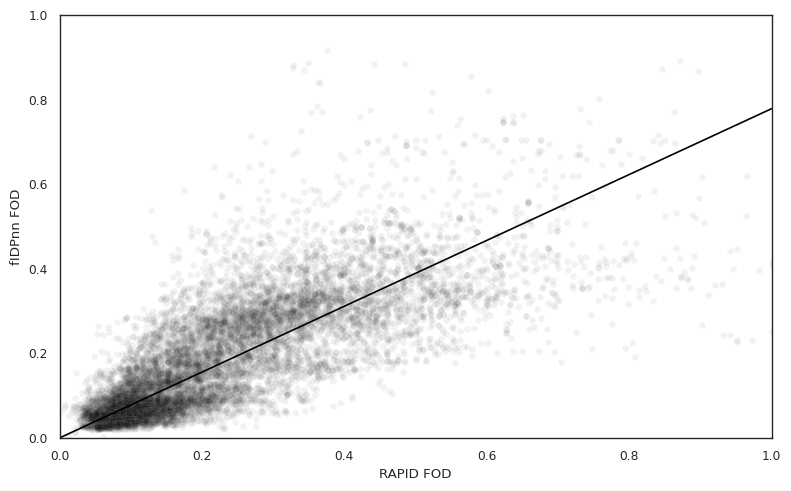

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(x=RAPID_calcs.values(), y=fIDPnn_calcs.values(), alpha=0.05, color='black')
ax.plot(model_comparison_ols.predict([0, 1]), color='black')

plt.ylabel('fIDPnn FOD')
plt.xlabel('RAPID FOD')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.tight_layout()
fig.show()
# fig.savefig('RAPID_vs_fIDPnn.svg')

RAPID seems to be an adequate model when compared with fIDPnn, even though it generally does **underpredict** disorder based on coefficient

In [ ]:
def plot_cluster(cluster_df):

  fIDP_disorder_dict = {}

  for id in cluster_df['ID']:
    try:
      df = fIDPnn_dfs[id]
      df['Predicted Score for Disorder'].plot()
    except:
      continue

In [ ]:
interesting_clusters['cluster'].unique()[:10]

array([239905, 739489, 864394, 896643, 865740, 845716, 730795, 891615,
       713553, 773025])

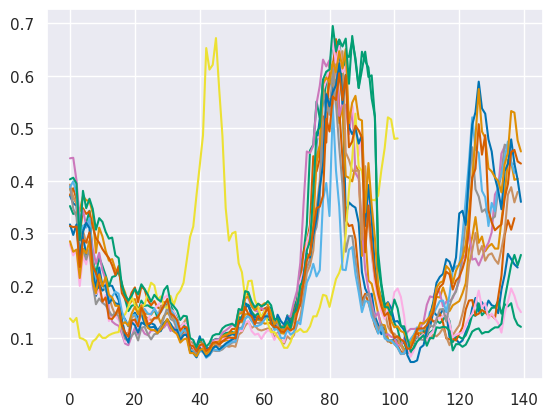

In [ ]:
plot_cluster(interesting_clusters[interesting_clusters['cluster']==773025])

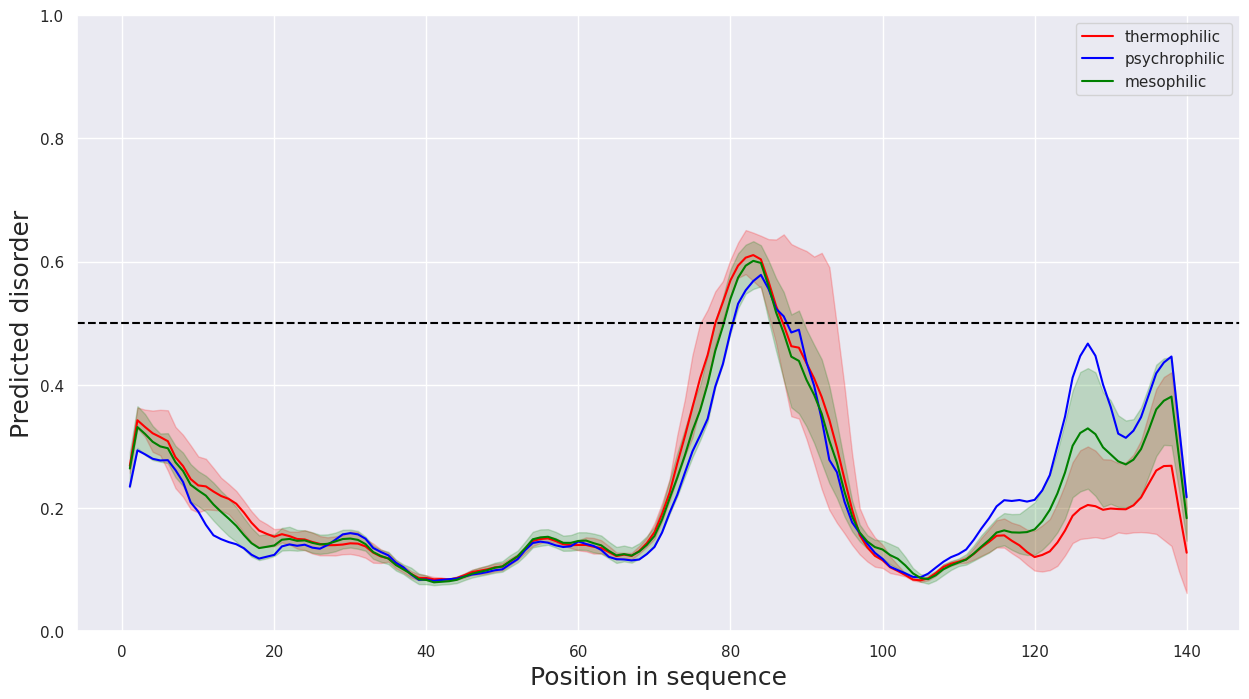

In [ ]:
test_cluster_n = 773025

test_cluster = interesting_clusters[interesting_clusters['cluster']==test_cluster_n].copy()

test_cluster['disorder_aligned'] = align_disorder(disorder_values=[fIDPnn_dfs[id]['Predicted Score for Disorder'] for id in test_cluster['ID']],
                                                  seqs=test_cluster['Sequence'], ids=test_cluster['ID'])[1]

test_cluster['group'] = [tempura[tempura['genus_and_species']==s]['group'].iloc[0] for s in test_cluster['Species']]

# test_cluster['color'] = test_cluster['group'].map({'psychrophilic':'blue',
#                                                    'mesophilic':'green',
#                                                    'thermophilic':'red'})
# test_cluster['species_tag'] = test_cluster['Species']

# plot_aligned_cluster(df=test_cluster, cluster=test_cluster_n, mav=10)

In [ ]:
interesting_cluster_sizes = {}

for cluster in tqdm(interesting_clusters['cluster'].unique()):
  try:
    cluster_df = interesting_clusters[interesting_clusters['cluster']==cluster].copy()
    cluster_df['disorder_aligned'] = align_disorder(disorder_values=[fIDPnn_dfs[id]['Predicted Score for Disorder'] for id in cluster_df['ID']],
                                                    seqs=cluster_df['Sequence'], ids=cluster_df['ID'])[1]

    cluster_df['group'] = [tempura[tempura['genus_and_species']==s]['group'].iloc[0] for s in cluster_df['Species']]
    interesting_cluster_sizes[cluster] = cluster_df.groupby('group').size()
  except:
    continue

100%|██████████| 607/607 [12:02<00:00,  1.19s/it]


In [ ]:
interesting_cluster_coverage ={}

for cluster in tqdm(interesting_cluster_sizes.keys()):
  interesting_cluster_coverage[cluster] = (interesting_cluster_sizes[cluster]/tempura.groupby('group').size()).fillna(0)

100%|██████████| 605/605 [00:02<00:00, 227.26it/s]


In [ ]:
sum(interesting_cluster_coverage.values())/len(interesting_cluster_coverage.values())

group
mesophilic       0.061307
psychrophilic    0.050767
thermophilic     0.029952
dtype: float64

In [ ]:
interesting_cluster_coverage[773025]

group
mesophilic       0.036232
psychrophilic    0.071429
thermophilic     0.090909
dtype: float64

## Contrast study

Download nt sequences for 16s genes of all species and save as `fasta` files

In [ ]:
# # Set your email address
# Entrez.email = 'akrug104@uottawa.ca'

# # Get the list of accession numbers and species names
# accession_list = tempura['16S_accssion'].tolist()
# species_list = tempura['genus_and_species'].tolist()

# # Add outgroup
# accession_list.append('NG_046384.1')
# species_list.append('Pyrobaculum ferrireducens')

# # Fetch the sequences from NCBI
# handle = Entrez.efetch(db='nucleotide', id=accession_list, rettype='fasta', retmode='text')
# records = list(SeqIO.parse(handle, 'fasta'))

# # Filter the records to only allow sequences up to 5000 nt long
# records = [r for r in  records if len(r.seq) <= 5000]

# # Save the sequences to a single fasta file
# with open('16S_all.fasta', 'w') as output_handle:
#     SeqIO.write(records, output_handle, 'fasta')

A sequence from an archaea was added as outgroup (NG_046384.1 of *Pyrobaculum ferrireducens*)

Alignment of sequences was done externally using MAFFT with default parameters except for specification for nucleotide sequences

In [ ]:
# # Read the fasta file
# records = SeqIO.parse('/content/16S_aligned.fasta', 'fasta')

# # Create a multiple sequence alignment object
# alignment = MultipleSeqAlignment(records)

# # Calculate the p-distance matrix
# calculator = DistanceCalculator('identity')
# distance_matrix = calculator.get_distance(alignment)

# with open('distance_matrix.txt', 'w') as f:
#   distance_matrix.format_phylip(f)

Tree has been constructed using UPGMA and saved in `Newick` format

In [ ]:
# # Construct the tree
# constructor = DistanceTreeConstructor()
# tree = constructor.upgma(distance_matrix)
# # Reroot the tree
# tree.root_with_outgroup({'name':'NG_046384.1'})
# # Save the tree in Newick format
# Phylo.write(tree, 'tree.nwk', format='newick')

1

Reading the tree if it has been created before

In [38]:
# Load the tree from a file
tree = Phylo.read('/content/IDP_analysis/datafiles/phylogenetics/tree.nwk', 'newick')

In [39]:
tree.root_with_outgroup({'name':'NG_046384.1'})

In [40]:
for t in tqdm(tree.get_terminals()):
  accession = t.name.split('.')[0]
  tempura_data = tempura[tempura['16S_accssion']==accession]
  t.OGT_contrast = 0
  t.FOD_contrast = 0
  t.is_leaf = True
  try:
    t.species = tempura_data['genus_and_species'].iloc[0]
    disorder_data = all_proteins_rapid[all_proteins_rapid['Species']==t.species]
    t.OGT = tempura_data['Topt_ave'].iloc[0]
    t.FOD = disorder_data['RAPID_disorder'].mean()
    if t.FOD == np.nan:
      print(t)
  except:
    t.species = 'OUTGROUP (Pyrobaculum ferrireducens)'
    t.OGT = 100
    t.FOD = 0.1184798938

100%|██████████| 311/311 [00:35<00:00,  8.82it/s]


In [41]:
for n in tqdm(tree.get_nonterminals()):
  n.species = n.name
  n.OGT = tempura['Topt_ave'].mean()
  n.FOD = all_proteins_rapid['RAPID_disorder'].mean()
  n.OGT_contrast = 0
  n.FOD_contrast = 0
  n.is_leaf = False

100%|██████████| 310/310 [00:01<00:00, 217.29it/s]


We will use LS minimization for quazi-independent contrasts to estimate OGT and MDS of internal nodes

In [42]:
def RSS_single(node, attribute, m=1):
  rss = 0.0
  distances = [c.branch_length for c in node.clades]
  for child, distance in zip(node.clades, distances):
    value_p = getattr(node, attribute)
    value_c = getattr(child, attribute)
    rss += ((value_p - value_c)**2) / distance**m
  return rss

def RSS_sum(nodes, attribute, m=1):
  return sum(RSS_single(node, attribute, m) for node in nodes)

def node_optimization(x0, nodes, attribute, m=1):
  # Assign values from the optimization parameters to internal nodes
  for i, node in enumerate(nodes):
    if not node.is_leaf:
      setattr(node, attribute, x0[i])

  # Calculate the total RSS for the tree
  total_rss = RSS_sum(nodes, attribute, m=m)

  return total_rss

In [43]:
nodes = [node for node in tree.get_nonterminals() + tree.get_terminals()][1:]

initial_guesses_OGT = [node.OGT for node in nodes]
initial_guesses_FOD = [node.FOD for node in nodes]

In [ ]:
node_optimization(initial_guesses_OGT, nodes, 'OGT', m=1)
OGT_result = scipy.optimize.minimize(node_optimization, initial_guesses_OGT, args=(nodes, 'OGT', 1))
print(f'RSS = {OGT_result.fun} with OGT:\n{OGT_result.x}')

In [ ]:
node_optimization(initial_guesses_FOD, nodes, 'FOD', m=1)
FOD_result = scipy.optimize.minimize(node_optimization, initial_guesses_FOD, args=(nodes, 'FOD', 1))
print(f'RSS = {FOD_result.fun} with FOD:\n{FOD_result.x}')

In [47]:
def calc_contrast(child_values:list):
  total_difference = sum(child_values[j] - child_values[i] for i in range(len(child_values)) \
                         for j in range(i+1, len(child_values)))
  contrast = total_difference/(len(child_values)*(len(child_values) - 1)/2)
  return contrast

In [48]:
# contrast calculation
for node in nodes:
  if not node.is_leaf:
    node.OGT_contrast = calc_contrast([child.OGT for child in node.clades])
    node.FOD_contrast = calc_contrast([child.FOD for child in node.clades])

In [49]:
OGTvsFOD = pd.DataFrame({'FOD':[node.FOD for node in nodes if not node.is_leaf],
                         'OGT':[node.OGT for node in nodes if not node.is_leaf],
                         'FOD_contrast':[node.FOD_contrast for node in nodes if not node.is_leaf],
                         'OGT_contrast':[node.OGT_contrast for node in nodes if not node.is_leaf]},
                        index=[node.name for node in nodes if not node.is_leaf])

<Axes: xlabel='OGT_contrast', ylabel='FOD_contrast'>

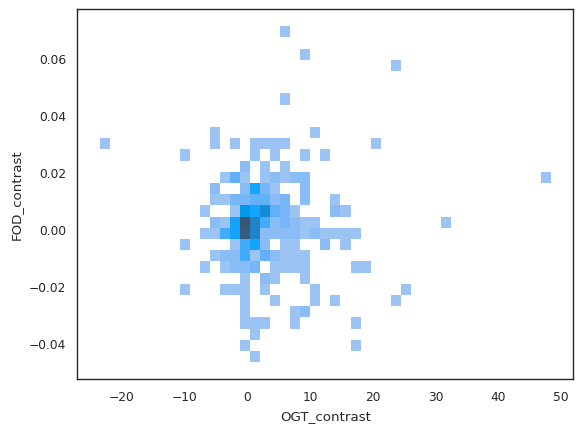

In [50]:
sns.histplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast')

<Axes: xlabel='OGT_contrast', ylabel='FOD_contrast'>

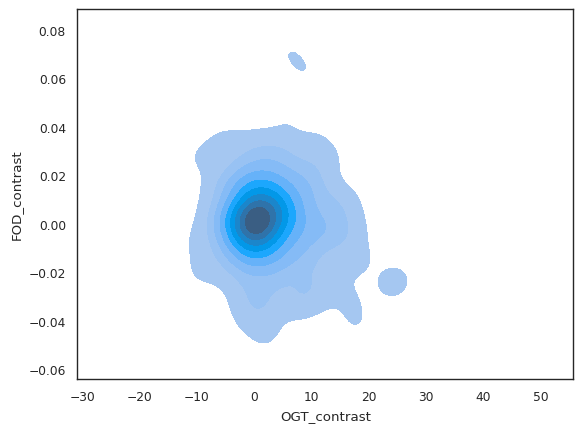

In [51]:
sns.kdeplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast', fill=True)

<Axes: xlabel='OGT_contrast', ylabel='FOD_contrast'>

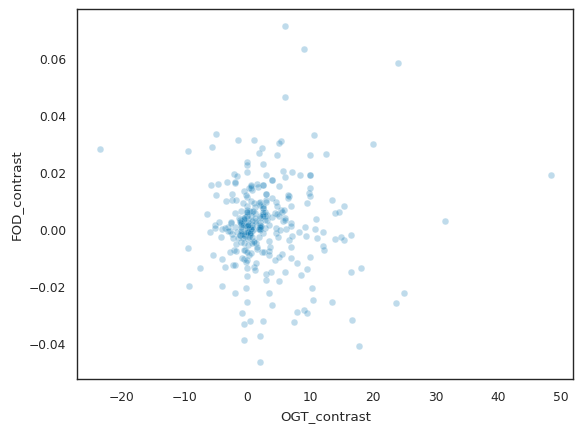

In [52]:
sns.scatterplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast', alpha=0.25)

In [53]:
OGTvsFOD_stats = scipy.stats.linregress(OGTvsFOD['OGT_contrast'], OGTvsFOD['FOD_contrast'])
OGTvsFOD_stats, OGTvsFOD_stats.rvalue**2

(LinregressResult(slope=-1.0672715514517473e-05, intercept=0.0016655289710560922, rvalue=-0.0045130203651971654, pvalue=0.9370242390411343, stderr=0.00013496899979209402, intercept_stderr=0.0009373171210907114),
 2.0367352816684356e-05)

Seems like when phylogeny is controlled for, there is no relationship between OGT and FOD

In [54]:
df = pd.DataFrame({'X':OGTvsFOD['OGT_contrast'],
                  'Y':OGTvsFOD['FOD_contrast']})

num_iterations = 10000
observed_corr, _ = scipy.stats.spearmanr(df['X'], df['Y'])

# Initialize an array to store resampled correlations
resampled_correlations = []

# Perform permutation testing (resampling)
for i in range(num_iterations):
    permuted_Y = np.random.permutation(df['Y'])  # Permute the Y values
    resampled_corr, _ = scipy.stats.spearmanr(df['X'], permuted_Y)
    resampled_correlations.append(resampled_corr)

# Calculate the p-value based on the resampled correlations
p_value = (np.abs(resampled_correlations) >= np.abs(observed_corr)).mean()
print("p-value:", p_value)

p-value: 0.6237


In [56]:
X = OGTvsFOD['OGT_contrast']
y = OGTvsFOD['FOD_contrast']

linear_model = sm.OLS(y, X).fit()

In [57]:
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           FOD_contrast   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.002
Method:                 Least Squares   F-statistic:                             0.4751
Date:                Fri, 01 Dec 2023   Prob (F-statistic):                       0.491
Time:                        16:13:38   Log-Likelihood:                          856.76
No. Observations:                 309   AIC:                                     -1712.
Df Residuals:                     308   BIC:                                     -1708.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

<Axes: xlabel='OGT_contrast', ylabel='FOD_contrast'>

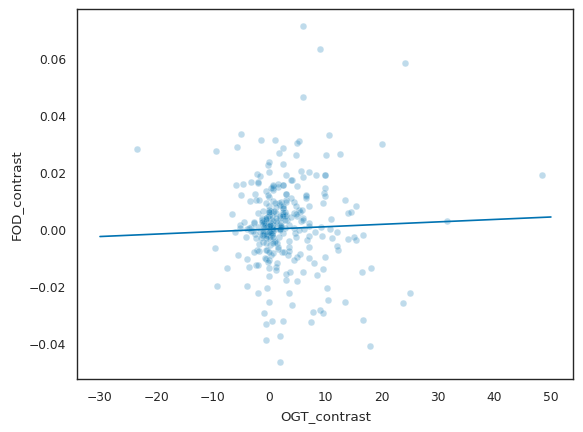

In [58]:
predictions = linear_model.predict([-30, 50])
sns.scatterplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast', alpha=0.25)
sns.lineplot(x=[-30, 50], y=predictions)

In [61]:
polynomial_model = sm.OLS(y, X**2).fit()
print(polynomial_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           FOD_contrast   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              2.139
Date:                Fri, 01 Dec 2023   Prob (F-statistic):                       0.145
Time:                        16:13:53   Log-Likelihood:                          857.60
No. Observations:                 309   AIC:                                     -1713.
Df Residuals:                     308   BIC:                                     -1709.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

<Axes: xlabel='OGT_contrast', ylabel='FOD_contrast'>

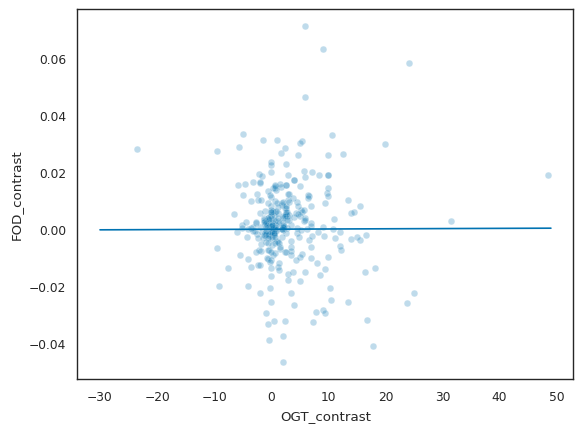

In [64]:
predictions = polynomial_model.predict(np.arange(-30, 50))
sns.scatterplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast', alpha=0.25)
sns.lineplot(x=np.arange(-30, 50), y=predictions)

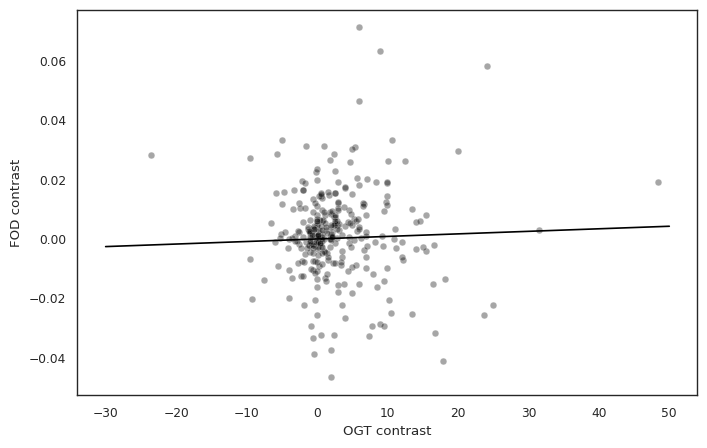

In [66]:
predictions = linear_model.predict([-30, 50])

fig, ax = plt.subplots(figsize=(8, 5))

plt.ylabel('FOD contrast')
plt.xlabel('OGT contrast')
sns.scatterplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast', alpha=0.35, color='black')
sns.lineplot(x=[-30, 50], y=predictions, color='black')
plt.show()

In [67]:
# fig.savefig('contrast.svg')